In [6]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import numpy as np
import pandas as pd
import torch
import math
import matplotlib as mpl

from data_pipeline.loader import FluDataLoader
import matplotlib.pyplot as plt

from PIL import Image


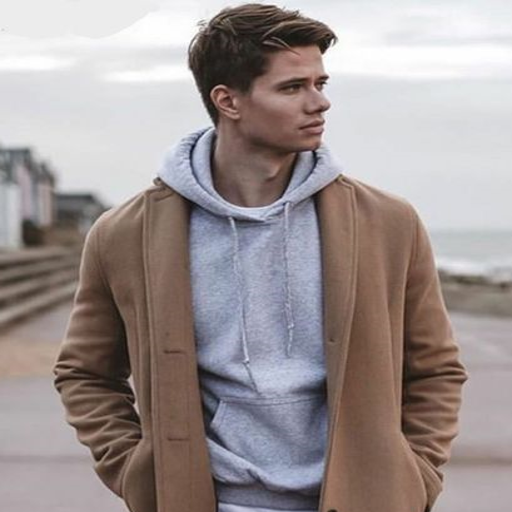

In [2]:
init_image = load_image(
    "boy.png"
)
init_image = init_image.resize((512, 512))
init_image

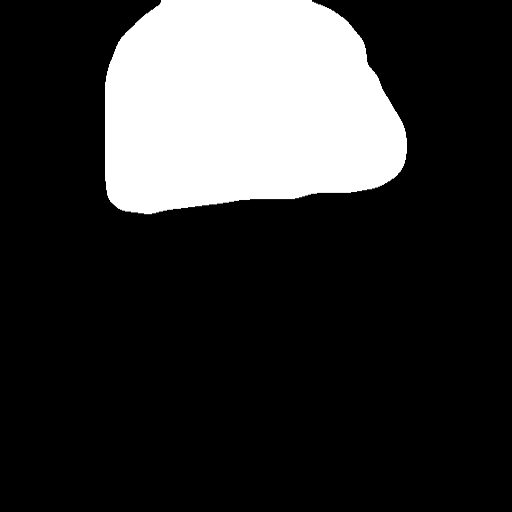

In [3]:

mask_image = load_image(
    "boy_mask.png"
)
mask_image = mask_image.resize((512, 512))
mask_image


In [79]:
generator = torch.Generator(device="cpu").manual_seed(1)


def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image


control_image = make_inpaint_condition(init_image, mask_image)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# generate image
image = pipe(
    "a handsome man with ray-ban sunglasses",
    num_inference_steps=20,
    generator=generator,
    eta=1.0,
    image=init_image,
    mask_image=mask_image,
    control_image=control_image,
).images[0]

Keyword arguments {'num_images_per_prompt': 100} are not expected by StableDiffusionControlNetInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

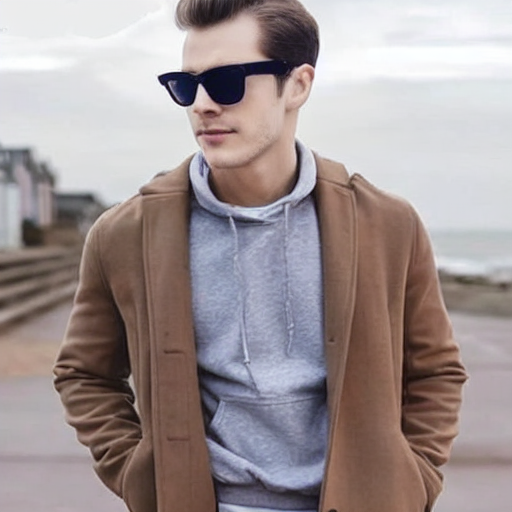

In [5]:
image

In [59]:
# as an example, assemble state level ILI+ data for states with < 75% missingness
fdl = FluDataLoader('../../data-raw')
flu_data = fdl.load_data() \
  .query('agg_level == "state" and source == "ilinet" and wk_end_date <= "2018-05-01" and location < "72"')

locations_to_drop = flu_data.groupby('location') \
  .apply(lambda x: np.mean(np.isnan(x['inc_4rt_cs']))) \
  .loc[lambda x: x >= 0.75] \
  .index

flu_data = flu_data.loc[~flu_data['location'].isin(locations_to_drop)]

train_df = flu_data.query('wk_end_date <= "2017-12-01"')
test_df = flu_data.query('wk_end_date > "2017-12-01"')

train_df

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
9252,state,01,2010/11,10.0,2010-10-09,0.003648,ilinet,4785437.0,15.381088,0.341793,1.875259,-0.332875,0.514173
9253,state,01,2010/11,11.0,2010-10-16,0.003648,ilinet,4785437.0,15.381088,0.341793,1.875259,-0.332875,0.514173
9254,state,01,2010/11,12.0,2010-10-23,0.145043,ilinet,4785437.0,15.381088,0.627499,1.875259,-0.181328,0.514173
9255,state,01,2010/11,13.0,2010-10-30,0.714826,ilinet,4785437.0,15.381088,0.922696,1.875259,-0.024747,0.514173
9256,state,01,2010/11,14.0,2010-11-06,1.810421,ilinet,4785437.0,15.381088,1.161564,1.875259,0.101956,0.514173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43470,state,56,2017/18,13.0,2017-10-28,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43471,state,56,2017/18,14.0,2017-11-04,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43472,state,56,2017/18,15.0,2017-11-11,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43473,state,56,2017/18,16.0,2017-11-18,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038


In [69]:
def df_to_img(df, location, time, value,
              horizon=1,
              max_obs_intensity = 0.8,
              shape=(512, 512)):
  '''
  Encode spatio-temporal data as an image, with masking values and scaling metadata
  
  Parameters
  ----------
  df: pandas data frame
    data frame with data to encode
  location, time, value: string
    names of columns in `df` containing a location identifier,
    time index, and value to be predicted.
  horizon: integer
    forecast horizon
  max_obs_intensity: float between 0 and 1
    maximum intensity of historical observations on a scale from 0 to 1.
    this determines an implicit cap on the largest prediction that can be generated.
    For example, if set to 0.5, the largest possible prediction is twice the largest
    historical observation.
  shape: integer tuple
    dimensions of output image in pixels
  
  Returns
  -------
  dictionary with four entries:
    control: control image, class PIL.Image
    mask: mask image, class PIL.Image
    location_index: locations in order used
    time_index: times in order used
    center: float used for centering
    scale: float used for scaling
  '''
  # convert data to wide format
  # locations in rows, times in columns
  df_wide = df[[location, time, value]] \
    .set_index([time, location]) \
    .unstack(time)
  df_wide.columns = df_wide.columns.droplevel(0)
  
  # append NA values on right hand side; this is what we will forecast
  forecast_times = pd.date_range(
    df_wide.columns[-1],
    periods = horizon + 1,
    freq = pd.infer_freq(df_wide.columns))[1:]
  
  df_wide = pd.concat(
    [df_wide, pd.DataFrame(index = df_wide.index, columns = forecast_times)],
    axis = 1)
  
  # extract data values as array; center and scale
  img = np.array(df_wide).astype(np.float32)
  
  a = np.nanmin(img)
  b = np.nanmax(img)
  center = a
  scale = (b - a) / max_obs_intensity
  
  img = (img - a) / scale
  
  # get image and mask as class PIL.Image
  mask = Image.fromarray(np.isnan(img)) \
    .resize(shape)
  
  img = Image.fromarray((img * 255).astype('int8'), mode = "L") \
    .resize(shape) \
    .convert("RGB")
  
  return {
    'control': img,
    'mask': mask,
    'location': location,
    'time': time,
    'value': value,
    'horizon': horizon,
    'location_index': df_wide.index,
    'time_index': df_wide.columns,
    'center': center,
    'scale': scale
  }


In [70]:
encoded_data = df_to_img(df=train_df,
                         location='location', time='wk_end_date', value='inc_4rt_cs',
                         horizon=26)

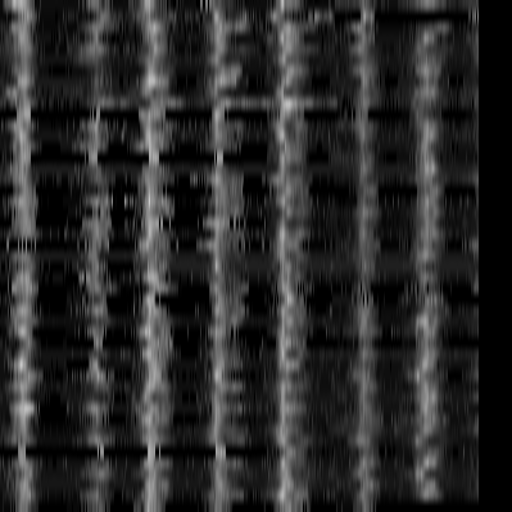

In [71]:
encoded_data['control']

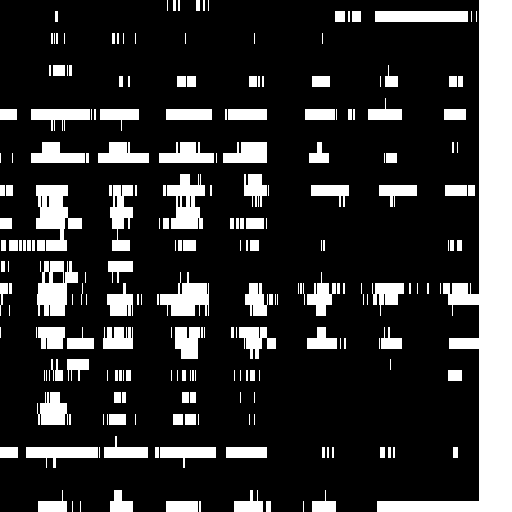

In [72]:
encoded_data['mask']

In [82]:
control_image = make_inpaint_condition(encoded_data['control'], encoded_data['mask'])

out_images = pipe(
  "a greyscale picture of waves viewed from above",
  num_inference_steps=50,
  generator=generator,
  eta=1.0,
  image=encoded_data['control'],
  mask_image=encoded_data['mask'],
  control_image=control_image,
  num_images_per_prompt = 10
).images

  0%|          | 0/50 [00:00<?, ?it/s]

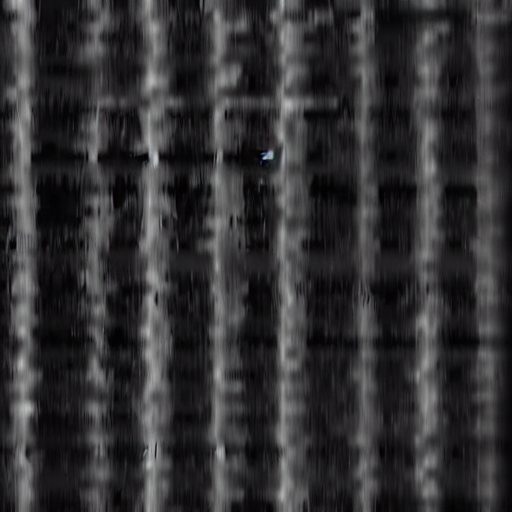

In [83]:
out_images[0]

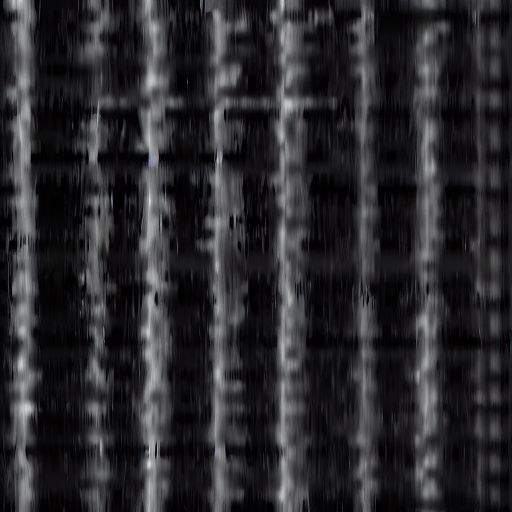

In [84]:
out_images[1]

In [124]:

def img_to_df(img, encoded_data, future_only=False):
  img_arr = img \
    .resize((len(encoded_data['time_index']), len(encoded_data['location_index']))) \
    .convert(mode="L")
  img_arr = np.array(img_arr).astype(np.float32) / 255.0
  img_arr = img_arr * encoded_data['scale'] + encoded_data['center']

  preds = pd.DataFrame(
    img_arr,
    index = encoded_data['location_index'],
    columns = encoded_data['time_index']) \
    .stack() \
    .reset_index() \
    .set_axis(labels = [encoded_data['location'],
                        encoded_data['time'],
                        encoded_data['value']],
              axis=1)

  return preds

preds = pd.concat(
  [ img_to_df(img, encoded_data).assign(sample_index = i) for i, img in enumerate(out_images) ],
  axis = 0)

# Undo some initial data transforms that were done by fdl.load_data():
# centering and scaling, fourth root transform
cs_factors = train_df.groupby('location', as_index=False) \
  [['location', 'inc_4rt_scale_factor', 'inc_4rt_center_factor']] \
  .head(1)

preds = preds.merge(cs_factors, on='location') \
  .assign(inc_4rt = lambda x: (x['inc_4rt_cs'] + x['inc_4rt_center_factor']) * (x['inc_4rt_scale_factor'] + 0.01)) \
  .assign(inc = lambda x: (np.maximum(x['inc_4rt'], 0.0) ** 4 - 0.01))

preds['inc'] = np.maximum(preds['inc'], 0.0)

preds

,location,wk_end_date,inc_4rt_cs,sample_index,inc_4rt_scale_factor,inc_4rt_center_factor,inc_4rt,inc
0,01,2010-10-09,-0.339468,0,1.875259,0.514173,0.329364,0.001768
1,01,2010-10-16,-0.295889,0,1.875259,0.514173,0.411522,0.018680
2,01,2010-10-23,-0.171377,0,1.875259,0.514173,0.646260,0.164433
3,01,2010-10-30,-0.065542,0,1.875259,0.514173,0.845787,0.501733
4,01,2010-11-06,-0.028188,0,1.875259,0.514173,0.916208,0.694654
...,...,...,...,...,...,...,...,...
187525,56,2018-04-28,-0.376822,9,1.704083,0.555038,0.305477,0.000000
187526,56,2018-05-05,-0.401724,9,1.704083,0.555038,0.262792,0.000000
187527,56,2018-05-12,-0.401724,9,1.704083,0.555038,0.262792,0.000000
187528,56,2018-05-19,-0.401724,9,1.704083,0.555038,0.262792,0.000000


In [105]:
len(train_df.groupby('location')['inc_4rt_center_factor'].unique())

47

In [134]:
test_df

,agg_level,location,season,season_week,wk_end_date,inc,source,pop,log_pop,inc_4rt,inc_4rt_scale_factor,inc_4rt_cs,inc_4rt_center_factor
9625,state,01,2017/18,18.0,2017-12-02,0.641519,ilinet,4874486.0,15.399525,0.898425,1.875259,-0.037621,0.514173
9626,state,01,2017/18,19.0,2017-12-09,0.751068,ilinet,4874486.0,15.399525,0.934019,1.875259,-0.018740,0.514173
9627,state,01,2017/18,20.0,2017-12-16,2.497005,ilinet,4874486.0,15.399525,1.258313,1.875259,0.153275,0.514173
9628,state,01,2017/18,21.0,2017-12-23,7.315463,ilinet,4874486.0,15.399525,1.645162,1.875259,0.358472,0.514173
9629,state,01,2017/18,22.0,2017-12-30,8.732749,ilinet,4874486.0,15.399525,1.719539,1.875259,0.397924,0.514173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43492,state,56,2017/18,35.0,2018-03-31,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43493,state,56,2017/18,36.0,2018-04-07,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43494,state,56,2017/18,37.0,2018-04-14,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038
43495,state,56,2017/18,38.0,2018-04-21,NaN,ilinet,578931.0,13.268939,NaN,1.704083,NaN,0.555038


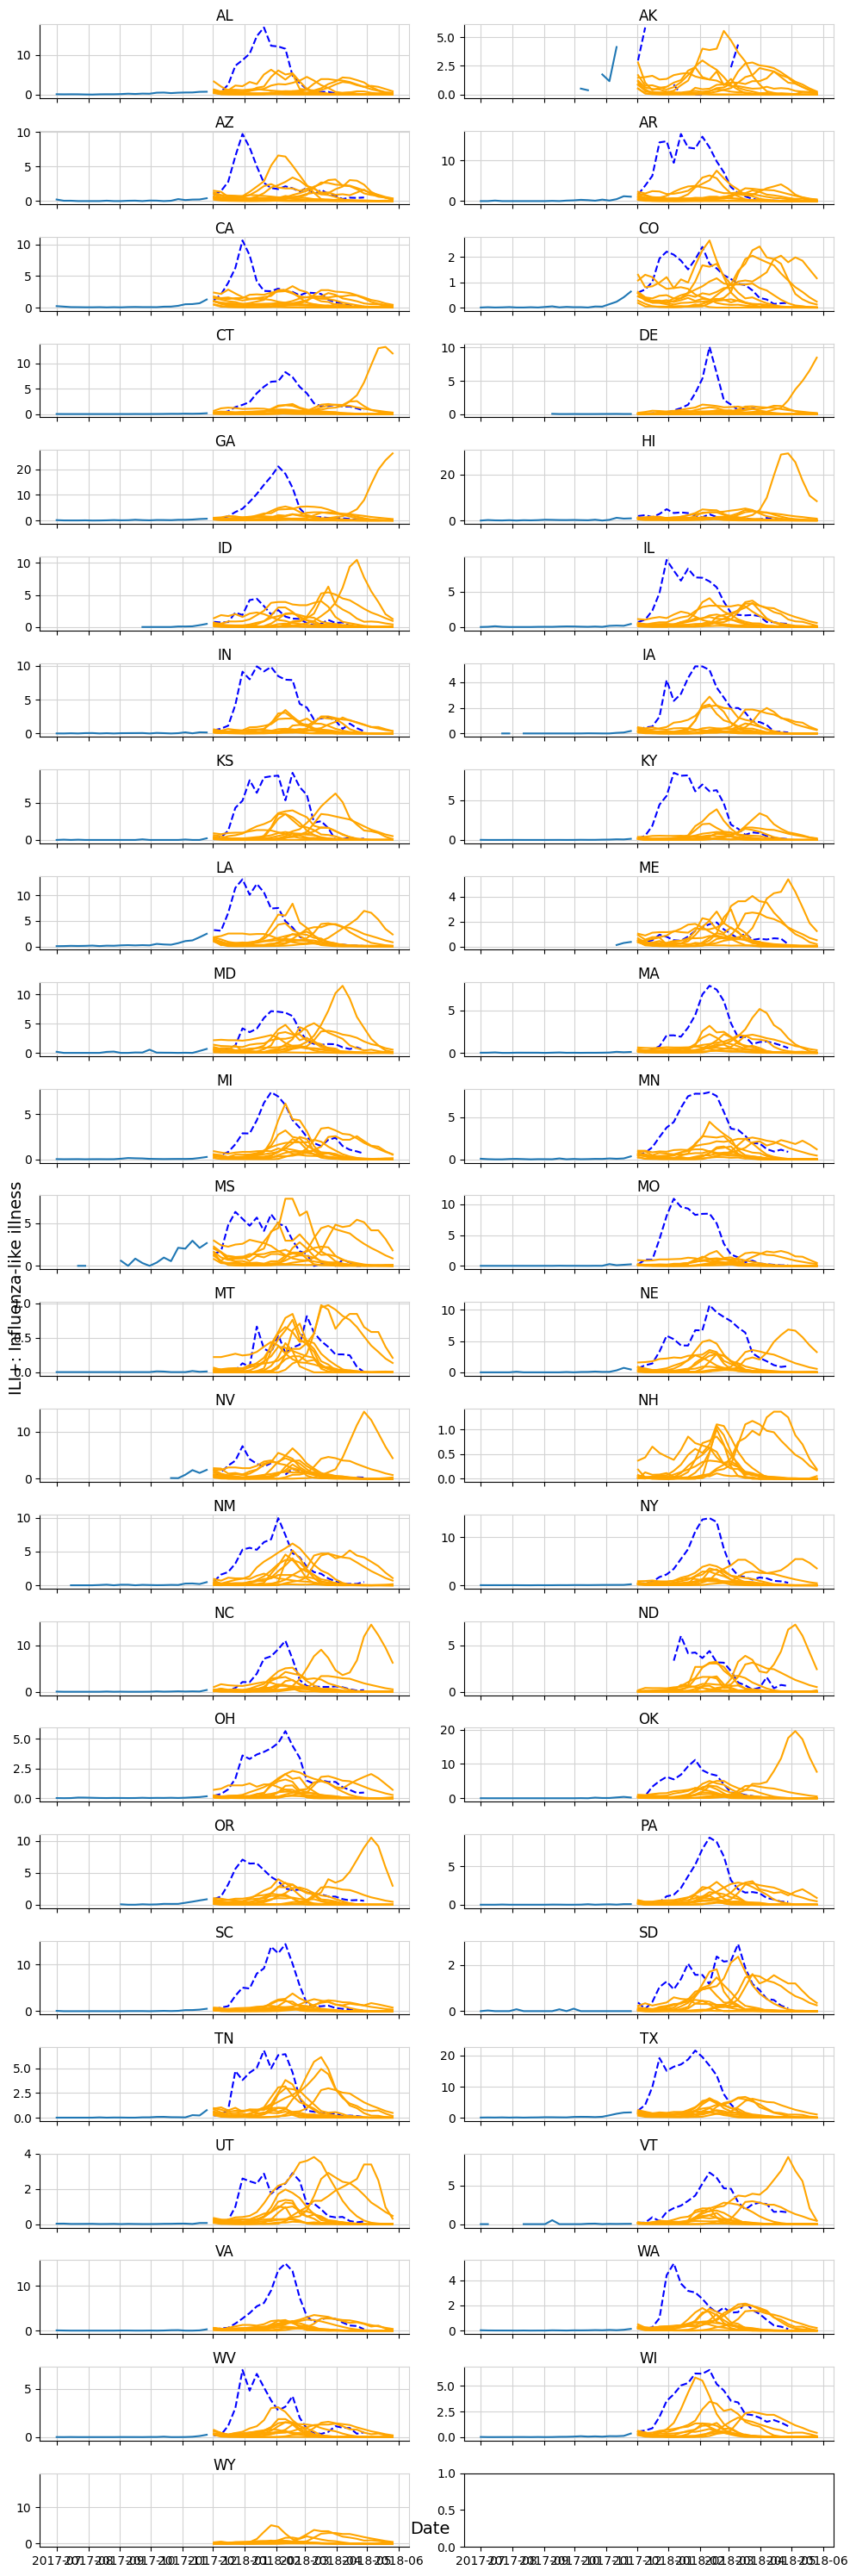

In [136]:
locs = preds['location'].unique()
nlocs = len(locs)

ncols = 2
nrows = math.ceil(nlocs / ncols)

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True, sharex=True, figsize=(10, 30))

fips = fdl.load_fips_mappings()

for ind, loc in enumerate(locs):
  i, j = np.unravel_index(ind, (nrows, ncols))
  ax[i, j].plot(
    'wk_end_date',
    'inc',
    '-',
    data = train_df.query(f'location == "{loc}" and wk_end_date >= "2017-07-01"'))
  
  ax[i, j].plot(
    'wk_end_date',
    'inc',
    '--',
    color = 'blue',
    data = test_df.query(f'location == "{loc}"'))
  
  for sample_index in preds['sample_index'].unique():
    ax[i, j].plot(
      'wk_end_date',
      'inc',
      '-',
      color = 'orange',
      data = preds.query(f'location == "{loc}" and wk_end_date >= "2017-12-01" and sample_index == {sample_index}'))
  
  ax[i, j].set_title(
    fips.query(f'location == "{loc}"')['abbreviation'].values[0],
    pad=0)
  ax[i, j].grid('on', linestyle='-', color='lightgrey')
  ax[i, j].spines['right'].set_color('lightgrey')
  ax[i, j].spines['top'].set_color('lightgrey')

fig.text(0.5, 0.02, 'Date', ha='center', va='center', size=14)
fig.text(0.02, 0.5, 'ILI+: Influenza-like illness',
         ha='center', va='center', rotation='vertical', size=14)

fig.set_tight_layout(True)